<a href="https://colab.research.google.com/github/HarshiniR4/Fall-2023-NYU-AI-hr2547/blob/main/Ass_2_part_1_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regression Model + CNN Model + Optuna Hyperparameter Tuning - IMDB Dataset**
# Harshini Raju

**NOTE**: Due to lack of GPU and Google Colab's limited resources my training has been constarined to a lower number than expected and/or required. 

**Importing the necessary libraries**


In [ ]:
%matplotlib inline

from keras.models import Sequential
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Flatten, MaxPooling2D
from keras.layers import Conv2D
from keras.optimizers import SGD, RMSprop, Adam
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from keras.callbacks import Callback

from distutils.version import LooseVersion as LV
from keras import __version__

from IPython.display import SVG
import tensorflow as tf
from keras.utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using Keras version: 2.13.1 backend: tensorflow


<ipython-input-3-90146d6af4d8>:30: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert(LV(__version__) >= LV("2.0.0"))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

Making use of the free GPU resources in Google Colab to enable better performance results than the local runtime.

In [ ]:
import tensorflow as tf
import keras
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

# **IMDB Dataset**

In [ ]:
from keras.datasets import imdb

# number of most-frequent words
nb_words = 10000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=nb_words)
word_index = imdb.get_word_index()

print('IMDB data loaded:')
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

1641221/1641221 [==============================] - 0s 0us/step
IMDB data loaded:
x_train: (25000,)
y_train: (25000,)
x_test: (25000,)
y_test: (25000,)


In [ ]:
print(x_train[0], "\nlength:", len(x_train[0]), "\nclass:", y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 
length: 218 
class: 1


In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[0]])
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

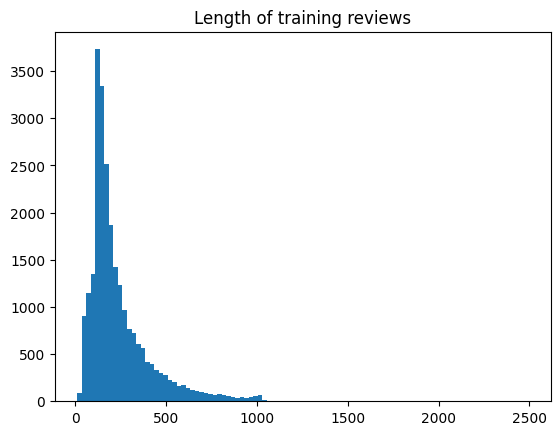

In [ ]:
l = []
for i in range(len(x_train)):
    l.append(len(x_train[i]))
plt.figure()
plt.title('Length of training reviews')
plt.hist(l,100);

As indicated by above plot the maximum number of words in the dataset have a length between 100-500. This will help us identify the maximum sequence length limit to be set later on.

# **Create the BoW feature vectors**

By reversing the indices in the dataset to the word using the Keras functionalities and then calculating that into the sparse matrix of token counts

In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
x_train_text = [' '.join([reverse_word_index.get(i - 3, '?') for i in sequence]) for sequence in x_train]

In [ ]:
max_sequence_length = 200
vectorizer = CountVectorizer(max_features=10000)
x_train_bow = vectorizer.fit_transform(x_train_text)

In [ ]:
x_test_text = [' '.join([reverse_word_index.get(i - 3, '?') for i in sequence]) for sequence in x_test]
x_test_bow = vectorizer.transform(x_test_text)

The sparse matrix that representsd the BoW feature for IMDB Dataset

In [ ]:
print(x_train_bow)

  (0, 8805)	3
  (0, 3420)	6
  (0, 9463)	11
  (0, 4841)	4
  (0, 1201)	3
  (0, 1440)	1
  (0, 5220)	1
  (0, 7579)	1
  (0, 8366)	2
  (0, 2565)	1
  (0, 3116)	2
  (0, 7027)	2
  (0, 8505)	1
  (0, 8763)	15
  (0, 6313)	1
  (0, 8789)	4
  (0, 6527)	2
  (0, 463)	9
  (0, 9741)	4
  (0, 2070)	1
  (0, 4415)	1
  (0, 919)	2
  (0, 8783)	2
  (0, 7370)	1
  (0, 4690)	1
  :	:
  (24999, 9632)	1
  (24999, 3299)	1
  (24999, 9081)	1
  (24999, 4235)	1
  (24999, 4582)	1
  (24999, 9388)	1
  (24999, 3323)	1
  (24999, 548)	1
  (24999, 535)	1
  (24999, 7161)	1
  (24999, 9431)	1
  (24999, 7172)	1
  (24999, 1603)	2
  (24999, 8055)	1
  (24999, 5077)	1
  (24999, 7753)	1
  (24999, 3963)	1
  (24999, 9446)	1
  (24999, 3461)	1
  (24999, 2150)	1
  (24999, 7513)	1
  (24999, 835)	1
  (24999, 1354)	1
  (24999, 7364)	1
  (24999, 819)	1


## **Pre-processing**
Vectorising the data and converting them into balanced and appropriate format of data that will be used as training and testing data for the Logistic Regression model

In [ ]:
def vectorize_sequences(sequences, dimension=nb_words):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [ ]:
# Convert training data to bag-of-words:
X_train = vectorize_sequences(x_train)
X_test = vectorize_sequences(x_test)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [ ]:
# Convert labels from integers to floats:
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [ ]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (25000, 10000)
y_train: (25000,)
X_test: (25000, 10000)
y_test: (25000,)


# **Implement the model- Logistic Regression**

In [ ]:
epochs = 175

Implementing a custom Callback function that will help me enable a recursive learnign rate value that follows the formula of

    learning_rate = previous_learning_rate/square_root(n)

where n is the number of the current epoch.

In [ ]:
# Write a custom Keras Callback function that allows to recursively modify learning_rate in every epoch
class LRScheduler(Callback):
    def __init__(self, initial_lr=0.001):
        super(LRScheduler, self).__init__()
        self.initial_lr = initial_lr

    def lr_schedule(self, epoch):
        return self.initial_lr / np.sqrt(epoch + 1)

    def on_epoch_begin(self, epoch, logs=None):
        new_lr = self.lr_schedule(epoch)
        self.model.optimizer.lr = new_lr
        print(f"Epoch {epoch + 1}: Learning rate set to {new_lr:.6f}")

In [ ]:
lr_adam_model = Sequential()
lr_adam_model.add(Dropout(0.5))
lr_adam_model.add(Dense(1, activation='sigmoid', input_shape=(10000,)))

# **Logistic Regression with Adam**

In [ ]:
optimizer = Adam(learning_rate=0.001)
lr_adam_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
lr_scheduler = LRScheduler(initial_lr=0.001)
lr_history = lr_adam_model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2, callbacks=[lr_scheduler])


score = lr_adam_model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1: Learning rate set to 0.001000
Epoch 1/175
157/157 [==============================] - 7s 12ms/step - loss: 0.5761 - accuracy: 0.7387 - val_loss: 0.4800 - val_accuracy: 0.8558
Epoch 2: Learning rate set to 0.000707
Epoch 2/175
157/157 [==============================] - 1s 7ms/step - loss: 0.4578 - accuracy: 0.8320 - val_loss: 0.4237 - val_accuracy: 0.8732
Epoch 3: Learning rate set to 0.000577
Epoch 3/175
157/157 [==============================] - 1s 8ms/step - loss: 0.4155 - accuracy: 0.8473 - val_loss: 0.3945 - val_accuracy: 0.8808
Epoch 4: Learning rate set to 0.000500
Epoch 4/175
157/157 [==============================] - 1s 7ms/step - loss: 0.3936 - accuracy: 0.8554 - val_loss: 0.3763 - val_accuracy: 0.8834
Epoch 5: Learning rate set to 0.000447
Epoch 5/175
157/157 [==============================] - 1s 9ms/step - loss: 0.3747 - accuracy: 0.8648 - val_loss: 0.3626 - val_accuracy: 0.8858
Epoch 6: Learning rate set to 0.000408
Epoch 6/175
157/157 [=============================

### Logistic Regression Plot using Adam Optimiser - Training and Validation loss comparsion

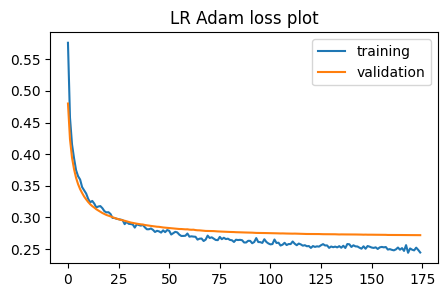

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(lr_history.epoch,lr_history.history['loss'], label='training')
plt.plot(lr_history.epoch,lr_history.history['val_loss'], label='validation')
plt.title('LR Adam loss plot')
plt.legend(loc='best')

## **Logistic Regression with SGD**

In [ ]:
lr_sgd_model = Sequential()
lr_sgd_model.add(Dropout(0.5))
lr_sgd_model.add(Dense(1, activation='sigmoid', input_shape=(10000,)))
optimizer = SGD(learning_rate=0.001)
lr_sgd_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
lr_scheduler = LRScheduler(initial_lr=0.001)
lr_history_sgd = lr_sgd_model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2, callbacks=[lr_scheduler])


score = lr_sgd_model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Epoch 1: Learning rate set to 0.001000
Epoch 1/175
157/157 [==============================] - 2s 10ms/step - loss: 0.6982 - accuracy: 0.5045 - val_loss: 0.6894 - val_accuracy: 0.5296
Epoch 2: Learning rate set to 0.000707
Epoch 2/175
157/157 [==============================] - 1s 8ms/step - loss: 0.6912 - accuracy: 0.5325 - val_loss: 0.6840 - val_accuracy: 0.5626
Epoch 3: Learning rate set to 0.000577
Epoch 3/175
157/157 [==============================] - 1s 6ms/step - loss: 0.6851 - accuracy: 0.5489 - val_loss: 0.6796 - val_accuracy: 0.5890
Epoch 4: Learning rate set to 0.000500
Epoch 4/175
157/157 [==============================] - 1s 7ms/step - loss: 0.6813 - accuracy: 0.5681 - val_loss: 0.6759 - val_accuracy: 0.6102
Epoch 5: Learning rate set to 0.000447
Epoch 5/175
157/157 [==============================] - 1s 7ms/step - loss: 0.6780 - accuracy: 0.5789 - val_loss: 0.6727 - val_accuracy: 0.6254
Epoch 6: Learning rate set to 0.000408
Epoch 6/175
157/157 [=============================

### Logistic Regression Plot using SGD Optimiser - Training and Validation loss comparsion

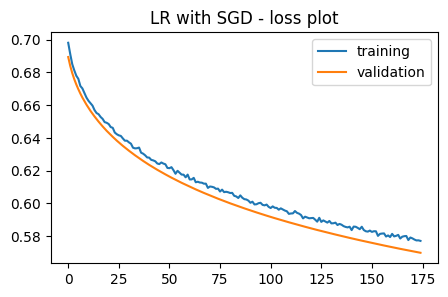

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(lr_history_sgd.epoch,lr_history_sgd.history['loss'], label='training')
plt.plot(lr_history_sgd.epoch,lr_history_sgd.history['val_loss'], label='validation')
plt.title('LR with SGD - loss plot')
plt.legend(loc='best')

### Logistic Regression Plot comparison using SGD and Adam - loss and validation

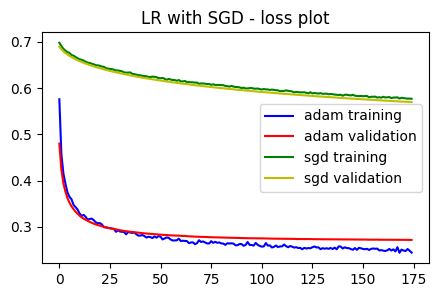

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(lr_history.epoch,lr_history.history['loss'], 'b', label='adam training',)
plt.plot(lr_history.epoch,lr_history.history['val_loss'], 'r', label='adam validation')
plt.plot(lr_history_sgd.epoch,lr_history_sgd.history['loss'], 'g', label='sgd training')
plt.plot(lr_history_sgd.epoch,lr_history_sgd.history['val_loss'], 'y', label='sgd validation')
plt.title('LR with SGD - loss plot')
plt.legend(loc='best')

**Inference:**


*   Adam performance is better than the SGD performance in terms of loss and validation loss
*  In Adam, model's loss and validation loss values are subsequently reducing as the epochs train whereas the SGD model's loss has compartively not reduced
*  While in both models the training and validation loss have been similar and very minimal difference is observed the range of reduction in loss value is higher in Adam when compared to SGD
*  Adam optimizer brings down the loss value drastically between the ffirst 25 epochs and hence the curve is deeper.
* SGD redcues the loss value incrementally in smaller installments hence the curve depth is much less and almsot falt in comparison to that of Adam optimizer


# **SGD and Adam Optimizers - Optuna**

In [ ]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.8 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
from optuna import Trial

def objective(trial: Trial):

    # Defining the hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6)

    # Form the layers of the model
    lr_adam_model = Sequential()
    lr_adam_model.add(Dropout(0.5))
    lr_adam_model.add(Dense(1, activation='sigmoid', input_shape=(10000,)))

    #choosing optimiser for current trail acording to the suggest functionality
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    print(f'Optimzer: {optimizer_name}')
    if optimizer_name == "Adam":
      optimizer = Adam(learning_rate=learning_rate)
    else:
      optimizer = SGD(learning_rate = learning_rate)

    # Compile the model with the chosen optimiser and binary_crossentropy loss function
    #               as it is a model to predict binary values- positive or negative
    lr_adam_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Defining the custom Keras callback that recursivley alters learning rate
    class CustomLRScheduler(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):

            new_lr = 1 / np.sqrt(epoch+1)
            K.set_value(self.model.optimizer.lr, new_lr)
            print(f'Epoch {epoch + 1}: Learning Rate = {new_lr}')

    lr_scheduler = CustomLRScheduler()

    # Train the model
    history = lr_adam_model.fit(
        X_train, y_train,
        epochs=15,
        batch_size=128,
        validation_data=(X_test, y_test),
        validation_batch_size=128,
        callbacks=[lr_scheduler],
        verbose=0
    )

    # Returning the value to monitored and minimised
    return history.history['val_loss'][-1]

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

# Get the best hyperparameters for Adam
best_params = study.best_params
# print("Best Hyperparameters:")
# print(adam_best_params)

trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-10-07 17:08:18,745] A new study created in memory with name: no-name-672ae1fe-7c71-42bc-98c7-bad61af2b333


Optimzer: Adam
Epoch 1: Learning Rate = 1.0
Epoch 2: Learning Rate = 0.7071067811865475
Epoch 3: Learning Rate = 0.5773502691896258
Epoch 4: Learning Rate = 0.5
Epoch 5: Learning Rate = 0.4472135954999579
Epoch 6: Learning Rate = 0.4082482904638631
Epoch 7: Learning Rate = 0.3779644730092272
Epoch 8: Learning Rate = 0.35355339059327373
Epoch 9: Learning Rate = 0.3333333333333333
Epoch 10: Learning Rate = 0.31622776601683794
Epoch 11: Learning Rate = 0.30151134457776363
Epoch 12: Learning Rate = 0.2886751345948129
Epoch 13: Learning Rate = 0.2773500981126146
Epoch 14: Learning Rate = 0.2672612419124244
Epoch 15: Learning Rate = 0.2581988897471611


[I 2023-10-07 17:08:59,233] Trial 0 finished with value: 5.234060764312744 and parameters: {'learning_rate': 0.012768829714604527, 'dropout_rate': 0.23640938032063727, 'optimizer': 'Adam'}. Best is trial 0 with value: 5.234060764312744.


Optimzer: Adam
Epoch 1: Learning Rate = 1.0
Epoch 2: Learning Rate = 0.7071067811865475
Epoch 3: Learning Rate = 0.5773502691896258
Epoch 4: Learning Rate = 0.5
Epoch 5: Learning Rate = 0.4472135954999579
Epoch 6: Learning Rate = 0.4082482904638631
Epoch 7: Learning Rate = 0.3779644730092272
Epoch 8: Learning Rate = 0.35355339059327373
Epoch 9: Learning Rate = 0.3333333333333333
Epoch 10: Learning Rate = 0.31622776601683794
Epoch 11: Learning Rate = 0.30151134457776363
Epoch 12: Learning Rate = 0.2886751345948129
Epoch 13: Learning Rate = 0.2773500981126146
Epoch 14: Learning Rate = 0.2672612419124244
Epoch 15: Learning Rate = 0.2581988897471611


[I 2023-10-07 17:09:34,918] Trial 1 finished with value: 5.4459662437438965 and parameters: {'learning_rate': 1.7453564032206774e-05, 'dropout_rate': 0.24461791138484248, 'optimizer': 'Adam'}. Best is trial 0 with value: 5.234060764312744.


Optimzer: SGD
Epoch 1: Learning Rate = 1.0
Epoch 2: Learning Rate = 0.7071067811865475
Epoch 3: Learning Rate = 0.5773502691896258
Epoch 4: Learning Rate = 0.5
Epoch 5: Learning Rate = 0.4472135954999579
Epoch 6: Learning Rate = 0.4082482904638631
Epoch 7: Learning Rate = 0.3779644730092272
Epoch 8: Learning Rate = 0.35355339059327373
Epoch 9: Learning Rate = 0.3333333333333333
Epoch 10: Learning Rate = 0.31622776601683794
Epoch 11: Learning Rate = 0.30151134457776363
Epoch 12: Learning Rate = 0.2886751345948129
Epoch 13: Learning Rate = 0.2773500981126146
Epoch 14: Learning Rate = 0.2672612419124244
Epoch 15: Learning Rate = 0.2581988897471611


[I 2023-10-07 17:10:11,509] Trial 2 finished with value: 0.2978297472000122 and parameters: {'learning_rate': 0.002718750801252578, 'dropout_rate': 0.5741212139629092, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.2978297472000122.


  Value:  0.2978297472000122
  Params: 
    learning_rate: 0.002718750801252578
    dropout_rate: 0.5741212139629092
    optimizer: SGD


In [ ]:
best_params= study.best_params
print("Best Hyperparameters for IMDB Dataset:")
print(best_params)

Best Hyperparameters for IMDB Dataset:
{'learning_rate': 0.002718750801252578, 'dropout_rate': 0.5741212139629092, 'optimizer': 'SGD'}


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

**NOTE: As the optuna plots are not visible when adding the Colab notebook to the repo I have added them as images for your simple reference**

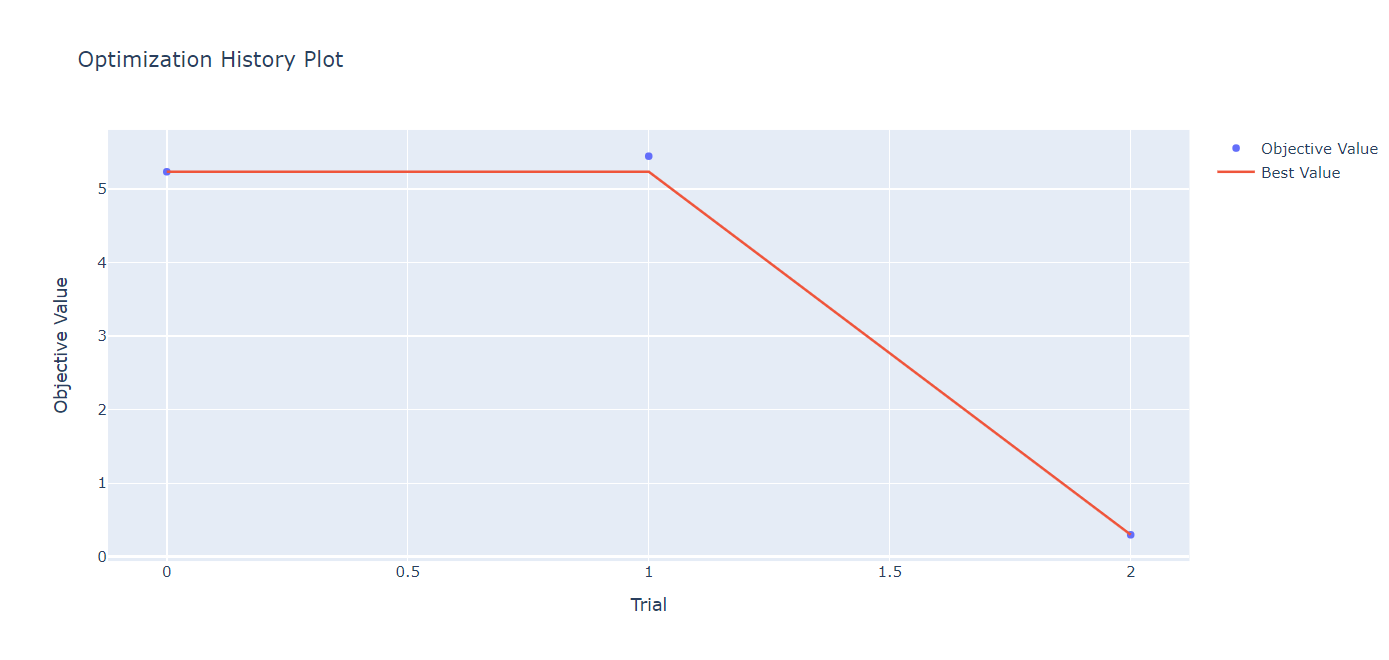

In [ ]:
fig = optuna.visualization.plot_contour(study, params=["learning_rate", "dropout_rate"])
fig.show()

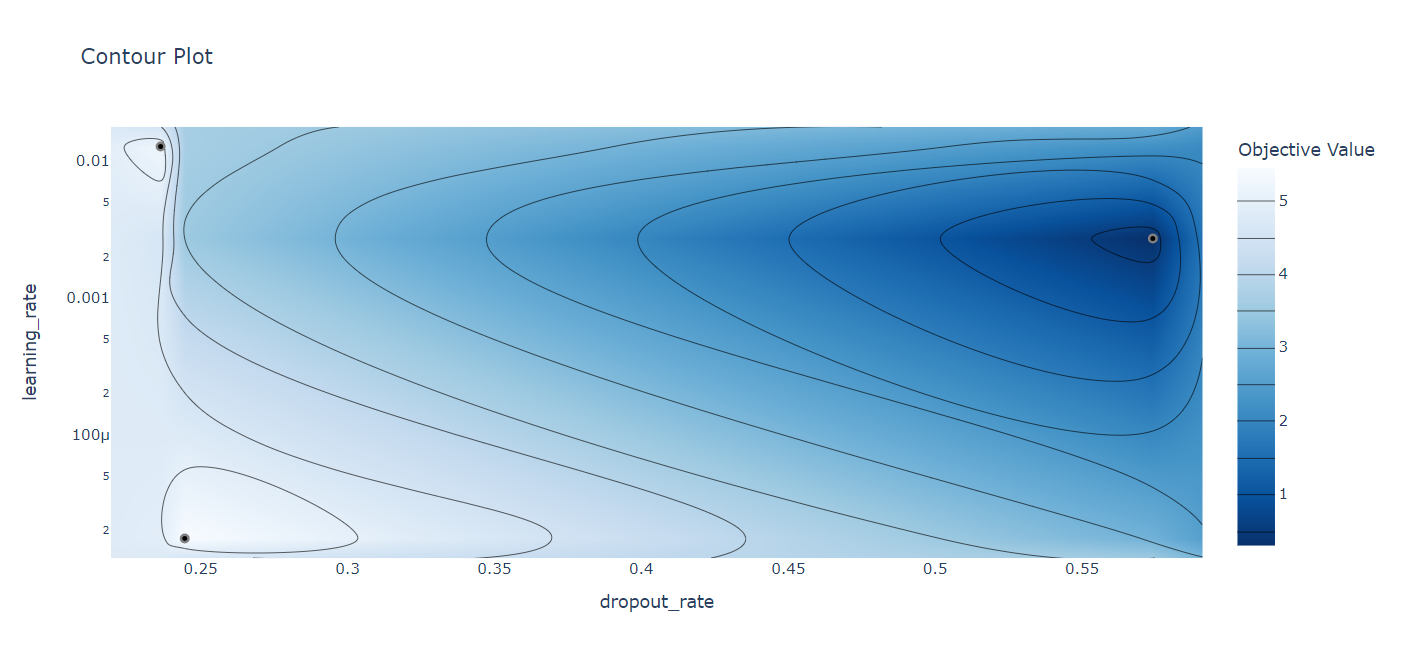

In [ ]:
fig = optuna.visualization.plot_contour(study, params=["learning_rate", "dropout_rate", "optimizer"])
fig.show()

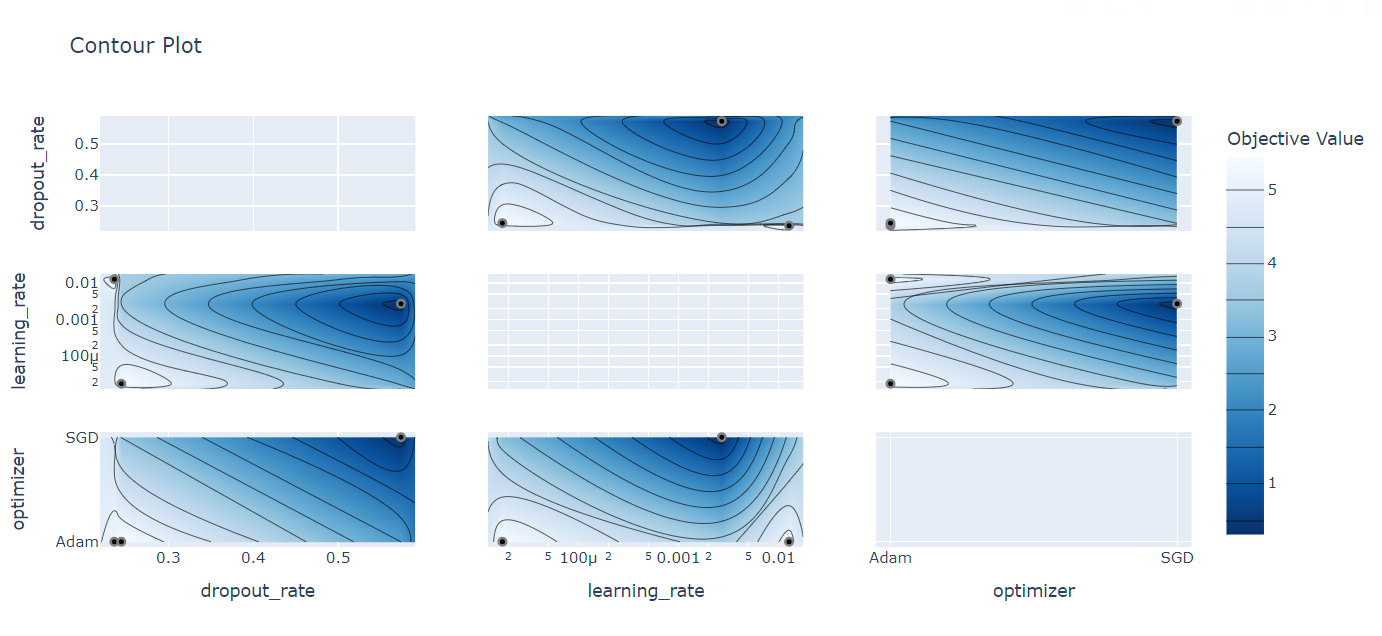

# Compare the results
After utilising Optuna to identify the hyperparameter that fits best and the optimizer that works best for the IMDB Dataset the following infferences can be made:
*   For this dataset and current training scenario, Optuna has declared SGD as the better optimiser
*  The best learnign value has been deemed to be 0.0027 when using SGD optimiszer
* In this particular scenario, since the learning rate and dropout parameter are being incrementally changed the SGD model is able to produce more stable results than otherwise
* From the Optuna contour plots we can infer that the dropout rates are significantlly lower while utilising Adam optimizer whereas the learning rates are lower while using SGD
*  The model has converged towards the sGD optimzer with a lower objective value as is visible from the contour plots. Thus SGD has done a better job at converging to a minima and minimising dropout rates than Adam, contradictory to popular examples

